IMPORTING REQUIRED PACKAGES

In [155]:
from packages_imp import*
np.random.seed(34)

#Importing functions from jupyter notebook
from ipynb.fs.full.dat_preprocess import*


In [156]:
# Loading data sets
train_data=pd.read_csv('train_initial_data.csv')
train_data.drop('RUL',axis=1,inplace=True)
test_data=pd.read_csv('test_initial_data.csv')
true_RUL=pd.read_csv('RUL_data.csv')
train_data_first_column = train_data['ENGINE_ID']
test_data_first_column = test_data['ENGINE_ID']
print(train_data)
print(test_data)

       ENGINE_ID  CONDITION_ID  Cycle_Time  OpSet1  OpSet2  OpSet3  \
0              1             1           1 -0.0007 -0.0004   100.0   
1              1             1           2  0.0019 -0.0003   100.0   
2              1             1           3 -0.0043  0.0003   100.0   
3              1             1           4  0.0007  0.0000   100.0   
4              1             1           5 -0.0019 -0.0002   100.0   
...          ...           ...         ...     ...     ...     ...   
20626        100             1         196 -0.0004 -0.0003   100.0   
20627        100             1         197 -0.0016 -0.0005   100.0   
20628        100             1         198  0.0004  0.0000   100.0   
20629        100             1         199 -0.0011  0.0003   100.0   
20630        100             1         200 -0.0032 -0.0005   100.0   

       SensorMeasure1  SensorMeasure2  SensorMeasure3  SensorMeasure4  ...  \
0              518.67          641.82         1589.70         1400.60  ...   
1  

In [157]:
# Calling gpu based torch model
import torch
torch.manual_seed(1) # No of instances
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

DECLARE THE VARIABLES TO BE USED

In [158]:
removed_columns=[]  # Stores the list of columns to be dropped

LOAD THE FINAL DATASET AFTER EDA

In [159]:
def call_EDA(file):
  filename=file
  res = pm.execute_notebook(
    'EDA_and_Feature_Selection.ipynb'  ,
    'CNN_LSTM_training_model.ipynb',
    parameters = dict(filename=filename),
    log_output=True,
    stdout_file=sys.stdout,
    stderr_file=sys.stderr,
    )
call_EDA('train_initial_data.csv')

Black is not installed, parameters wont be formatted
Executing:  30%|███       | 6/20 [00:06<00:11,  1.21cell/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ENGINE_ID        20631 non-null  int64  
 1   CONDITION_ID     20631 non-null  int64  
 2   Cycle_Time       20631 non-null  int64  
 3   OpSet1           20631 non-null  float64
 4   OpSet2           20631 non-null  float64
 5   OpSet3           20631 non-null  float64
 6   SensorMeasure1   20631 non-null  float64
 7   SensorMeasure2   20631 non-null  float64
 8   SensorMeasure3   20631 non-null  float64
 9   SensorMeasure4   20631 non-null  float64
 10  SensorMeasure5   20631 non-null  float64
 11  SensorMeasure6   20631 non-null  float64
 12  SensorMeasure7   20631 non-null  float64
 13  SensorMeasure8   20631 non-null  float64
 14  SensorMeasure9   20631 non-null  float64
 15  SensorMeasure10  20631 non-null  float64
 16  SensorMeasure11  20631 non-null  float64
 17  SensorMeasur

Executing:  40%|████      | 8/20 [00:08<00:09,  1.23cell/s]

Columns without data: 
[]



Executing:  50%|█████     | 10/20 [00:09<00:08,  1.23cell/s]

Columns with constant values: 
['CONDITION_ID', 'OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']



Executing:  80%|████████  | 16/20 [00:14<00:03,  1.05cell/s]

[0.03641634 0.03041575 0.03160112 0.05780225 0.04006594 0.02238824
 0.02854597 0.58667719 0.06580032 0.02174512 0.02566205 0.04262369
 0.01025602]


Executing: 100%|██████████| 20/20 [00:16<00:00,  1.19cell/s]


In [160]:
#Reading the list of columns to be dropped from training and test files from removed_columns.data
import pickle

with open('removed_columns.data', 'rb') as filehandle:
    # Read the data as a binary data stream
    removed_columns = pickle.load(filehandle)
removed_columns

['ENGINE_ID',
 'OpSet1',
 'OpSet2',
 'CONDITION_ID',
 'OpSet3',
 'SensorMeasure1',
 'SensorMeasure5',
 'SensorMeasure6',
 'SensorMeasure10',
 'SensorMeasure16',
 'SensorMeasure18',
 'SensorMeasure19']

In [161]:
#Delete columns from removed_columns which are not required

In [162]:
#VARIABLES
Epochs=350
WINDOW_SIZE=30
BATCH_SIZE = 210   # No of samples processed before model is updated
WINDOW_LENGTH = 30
SHIFT = 1
EARLY_RUL = 100  # clipping parameter of RUL. RUL above this values are all treated as same   
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
NUM_TEST_WINDOWS = 40 # Default value 1 
processed_test_data = []
num_test_windows_list = []


In [163]:
#Process target RUL 
def process_target_RUL(data_length, early_rul = None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:   # 
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [164]:
# Creating a numpy array with tuple containing feature and labels
def process_dataset_with_target_RUL(input_data, target_data = None, window_length = 1, shift = 1):
    """
    Description:
    
    Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches taken as a function of engine ID = np.floor((len(input_data) - window_length)/shift) + 1
    
    **Input dimensions have not been checked and considered to be at par with the requirements**
    
    Arguments:
        input_data: input data to function (2D array containing features and label)
        target_data: input RUL values (1D array)
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [165]:
#Preparing the feature target array for test data
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ 
    Process:
    
    Function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many samples we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_dataset_with_target_RUL(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_dataset_with_target_RUL(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [166]:
# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))  # Scale the values of the features between -1 to 1
train_data = scaler.fit_transform(train_data.drop(columns = removed_columns))
test_data = scaler.transform(test_data.drop(columns = removed_columns))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

Process training and test data sepeartely as number of engines in training and test set may be different.
As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

In [167]:
# Process train data as input dataset in the CNN
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < WINDOW_LENGTH):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, WINDOW_LENGTH))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_target_RUL(data_length = temp_train_data.shape[0], early_rul = EARLY_RUL)
    data_for_a_machine, targets_for_a_machine = process_dataset_with_target_RUL(temp_train_data, temp_train_targets, 
                                                                                window_length = WINDOW_LENGTH, shift = SHIFT)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

C:\Users\kanad\AppData\Local\Temp\ipykernel_8736\4265167990.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1


In [168]:
# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < WINDOW_LENGTH):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, WINDOW_LENGTH))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = WINDOW_LENGTH, shift = SHIFT,
                                                             num_test_windows = NUM_TEST_WINDOWS)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_RUL = (true_RUL['0'].values).clip(max=EARLY_RUL)  # CLIPPING Values
true_RUL

C:\Users\kanad\AppData\Local\Temp\ipykernel_8736\3675716629.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
C:\Users\kanad\AppData\Local\Temp\ipykernel_8736\4265167990.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

array([100,  98,  69,  82,  91,  93,  91,  95, 100,  96,  97, 100,  95,
       100,  83,  84,  50,  28,  87,  16,  57, 100, 100,  20, 100, 100,
        66,  97,  90, 100,   8,  48, 100,   7,  11,  19,  21,  50, 100,
        28,  18,  10,  59, 100, 100,  47, 100,  92,  21,  79, 100,  29,
        26,  97, 100,  15, 100,  37, 100, 100,  21,  54,  72,  28, 100,
        14,  77,   8, 100,  94, 100,  50, 100, 100, 100,  10,  34, 100,
        63,  90,   8,   9, 100,  58, 100,  89, 100, 100, 100,  28,  38,
        20,  85,  55, 100, 100,  82,  59, 100,  20], dtype=int64)

In [169]:
# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed training data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_RUL.shape)

Processed training data shape:  (17731, 30, 15)
Processed training ruls shape:  (17731,)
Processed test data shape:  (3723, 30, 15)
True RUL shape:  (100,)


In [170]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 15)
Processed validation data shape:  (3547, 30, 15)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [171]:
# Import packages required for CNN_LSTM model
from keras.models import Sequential
from keras.layers import Dense, Conv1D   #Conv1D is used for 1D array shapes especially when data is stored in form of batches
from keras.layers import Dropout, Input
from keras import initializers
from keras.layers import MaxPooling1D
from keras.models import Model 
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM

In [172]:
'''
Learn and understand the effect of different parameters
'''
# Declare important variables
Learning_rate=0.001   #defined as lr in function
# Create Model
def create_compiled_model(lr=0.001, drop_CNN=0, drop_dense=0.2, kernel_size=3):
    model = Sequential()
    intput_shape=(WINDOW_LENGTH, processed_train_data.shape[2])
    model.add(Conv1D(128, kernel_size=kernel_size, padding = "same", activation="relu", input_shape = intput_shape))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Conv1D(128,kernel_size=kernel_size, padding = "same", activation="relu"))
    model.add(Dropout(drop_CNN))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units = 128, return_sequences=True))
    model.add(LSTM(units = 128, return_sequences=False))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(drop_dense))
    model.add(Dense(1, activation = 'linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')

    return model

In [173]:
# Model Creation and call
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()  # creating model
history = model.fit(processed_train_data, processed_train_targets, epochs = Epochs,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 60, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/350
237/237 - 9s - loss: 1144.2258 - val_loss: 162.0168 - lr: 0.0010 - 9s/epoch - 36ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/350
237/237 - 7s - loss: 160.4829 - val_loss: 111.9628 - lr: 0.0010 - 7s/epoch - 28ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/350
237/237 - 7s - loss: 108.3694 - val_loss: 71.9131 - lr: 0.0010 - 7s/epoch - 29ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/350
237/237 - 7s - loss: 87.3197 - val_loss: 72.8397 - lr: 0.0010 - 7s/epoch - 29ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/350
237/237 - 7s - loss: 76.3469 - val_loss: 49.9174 - lr: 0.0010 - 7s/epoch - 29ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/350
237/237 - 7s - loss: 73.6654 - val_loss: 49.7696 - lr: 0.0010 - 7s/epoch - 30ms/step

Epoch 7: LearningRateSchedu

In [174]:
""""
plt.figure()
plt.xlabel('Epoch')
plt.plot(history['epoch'], np.array(history['loss']), label='Train Loss')
plt.plot(history['epoch'], np.array(history['val_loss']), label = 'Validation loss')
plt.legend()
"""

'"\nplt.figure()\nplt.xlabel(\'Epoch\')\nplt.plot(history[\'epoch\'], np.array(history[\'loss\']), label=\'Train Loss\')\nplt.plot(history[\'epoch\'], np.array(history[\'val_loss\']), label = \'Validation loss\')\nplt.legend()\n'

In [175]:
#Provide model summary as output
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 30, 128)           5888      
                                                                 
 dropout_9 (Dropout)         (None, 30, 128)           0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 15, 128)           49280     
                                                                 
 dropout_10 (Dropout)        (None, 15, 128)           0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 8, 128)           0         
 1D)                                                  

In [176]:
#Calculate RMSE
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_RUL, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

117/117 [==============================] - 2s 8ms/step
RMSE:  17.080773772005205


In [177]:
#Save model
#torch.save(model, "turbofan_initial.pt")  
model.save("initial_train_fulldataset_model.h5")

In [178]:
#Compute the RMSE by taking only last example of each engine.

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]
#print((preds_for_each_engine))
RMSE_new = np.sqrt(mean_squared_error(true_RUL, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  8.937622571137158


In [179]:
#Compute S score
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
s_score = compute_s_score(true_RUL, preds_for_last_example)
print("S-score: ", s_score)

S-score:  116.68379529523526


In [180]:
test_data=pd.read_csv('test_initial_data.csv')
main_li=[]
k=1
for i in preds_for_each_engine:
    time_length=len(test_data[test_data['ENGINE_ID']==k].Cycle_Time)
    time_li_eng=[]
    for j in range(0,41):
        time_li_eng.append(j+true_RUL[k-1])
    main_li.append(time_li_eng)
    k=k+1
print(main_li)


[[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140], [98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138], [69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109], [82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122], [91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131], [93, 94, 95, 96, 97, 98,

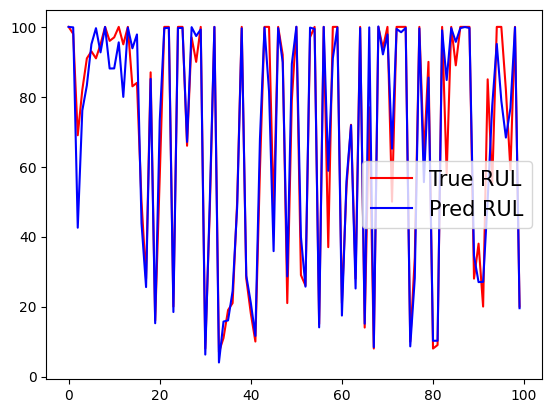

In [181]:
# Plot true and predicted RUL values
def plot(true_RUL,preds_for_last_example):
  SMALL_SIZE=10
  MEDIUM_SIZE=15
  BIGGER_SIZE=15
  plt.plot(true_RUL, label = "True RUL", color = "red")
  plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
  plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
  plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
  plt.legend(fontsize=15)
  plt.show()
plot(true_RUL,preds_for_last_example)

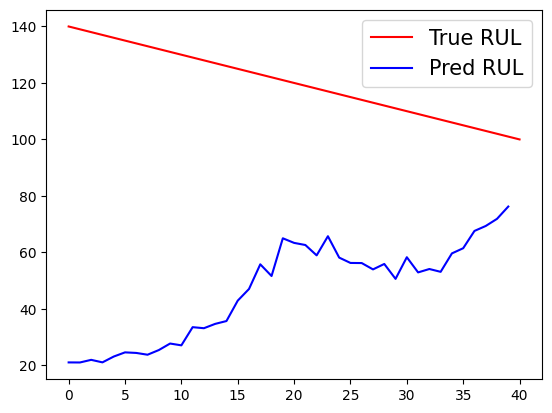

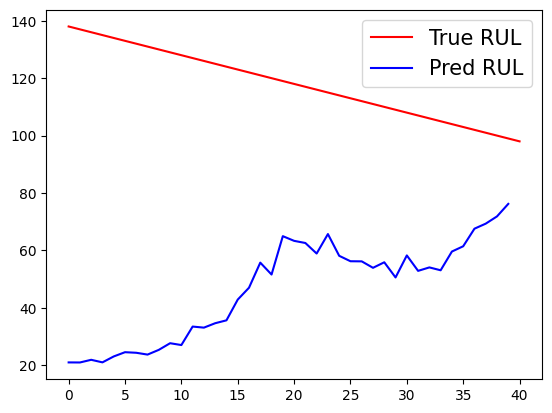

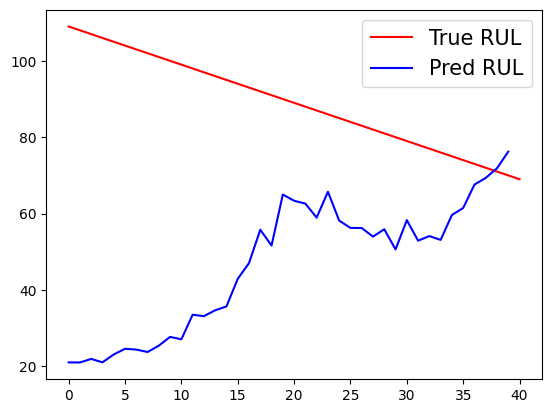

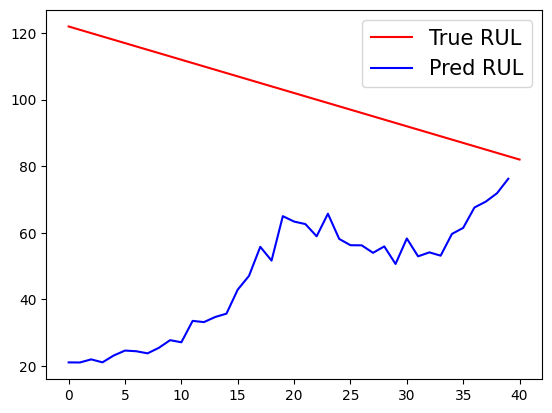

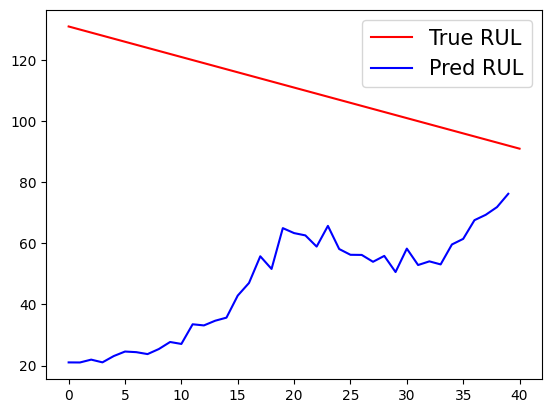

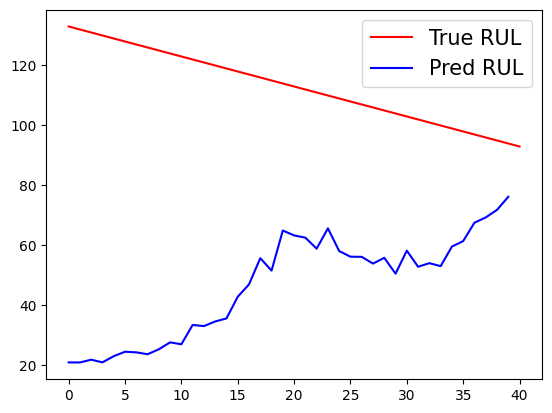

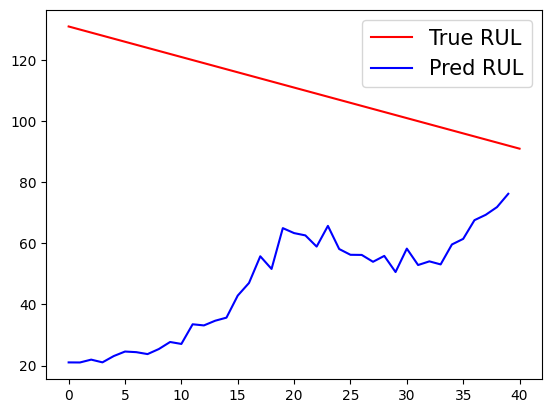

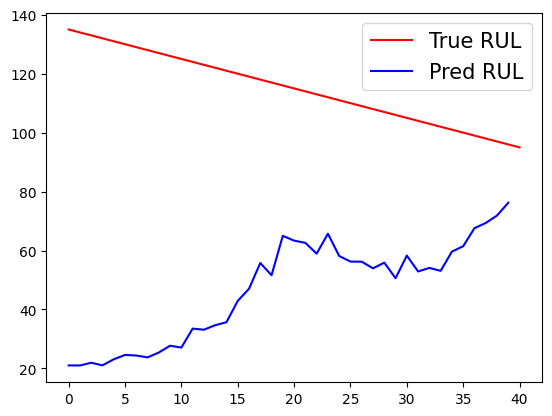

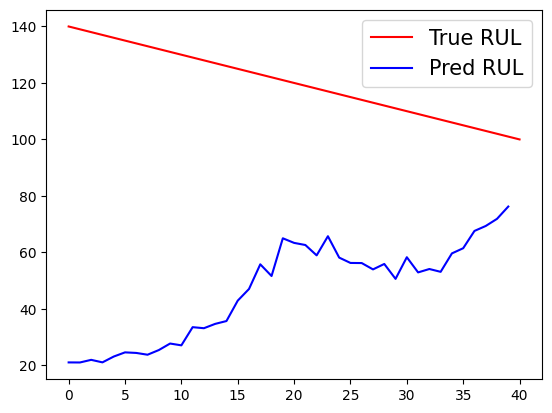

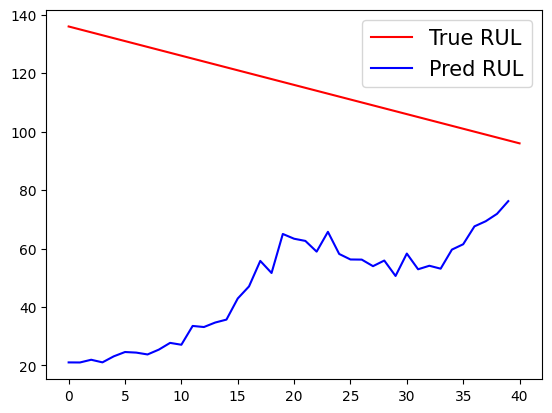

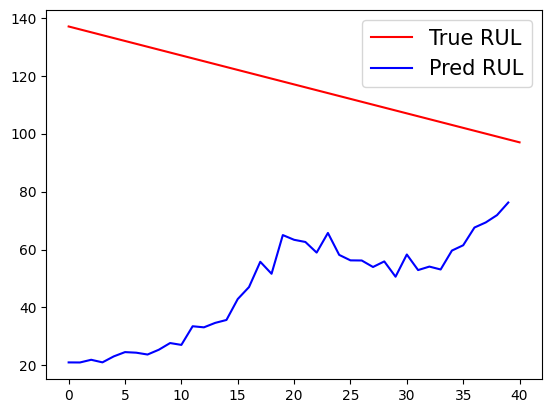

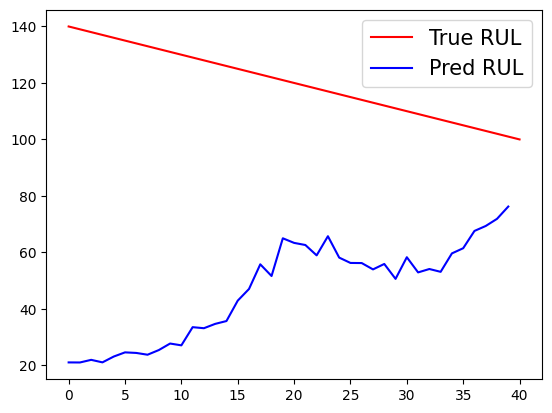

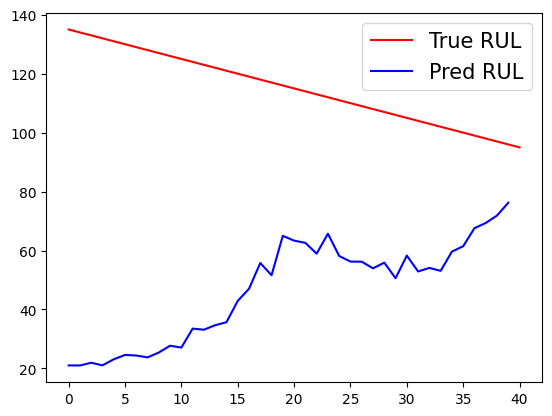

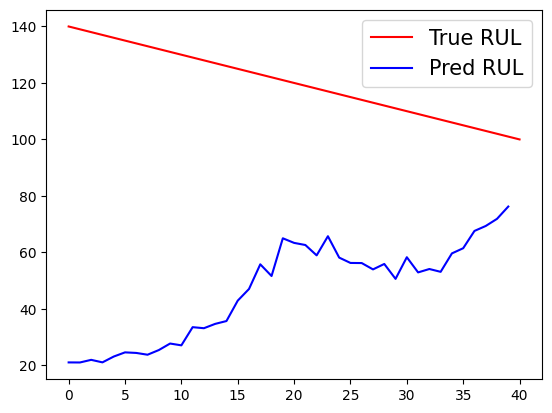

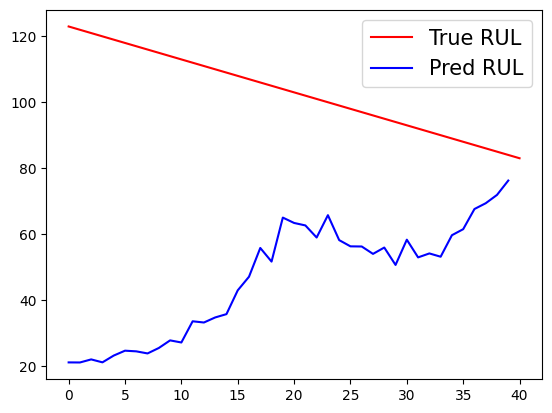

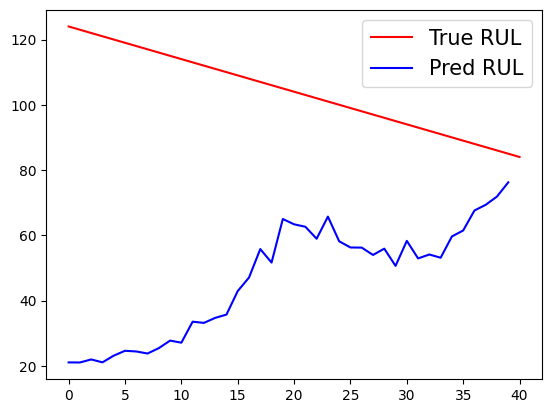

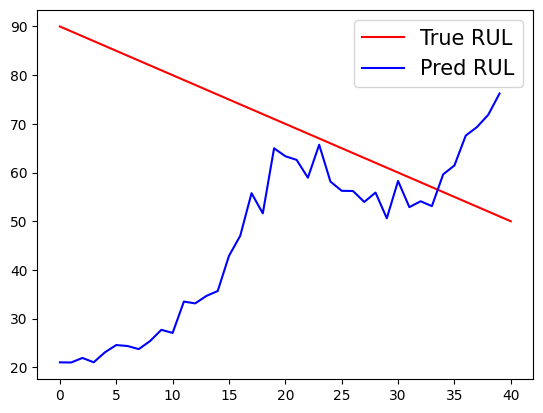

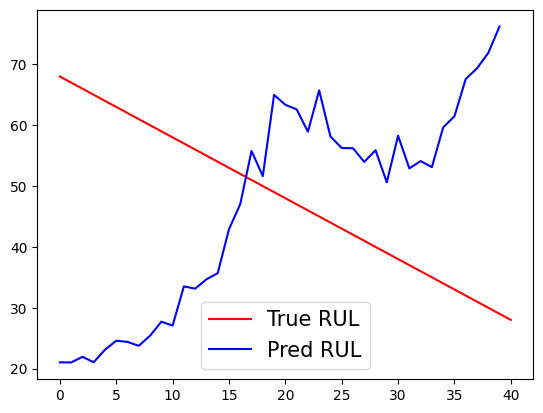

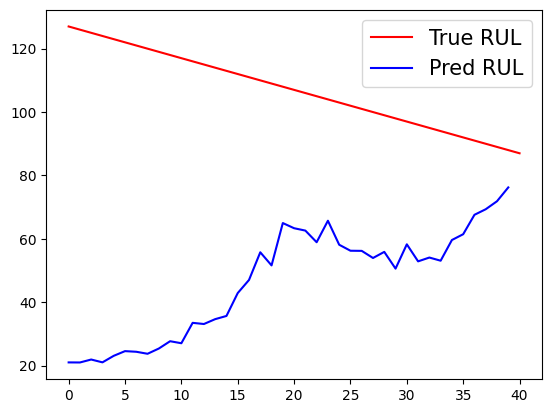

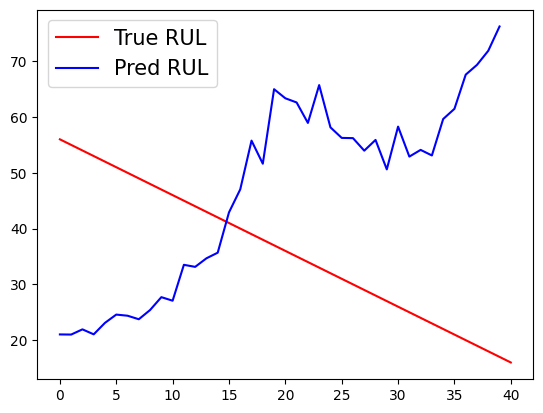

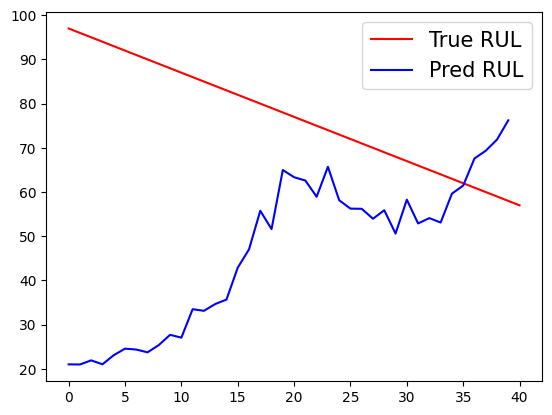

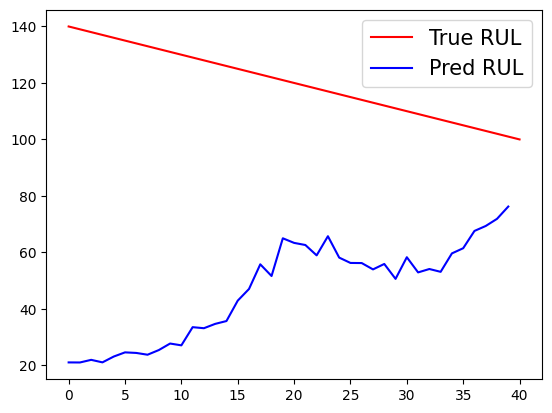

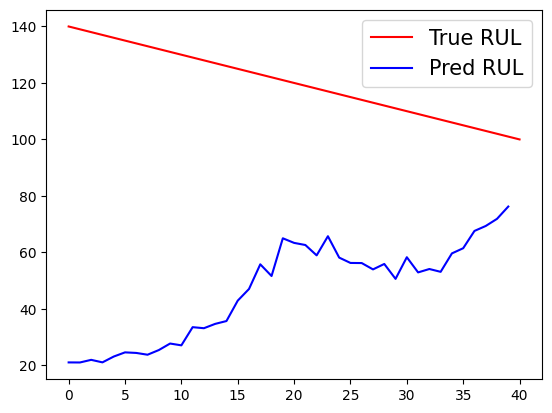

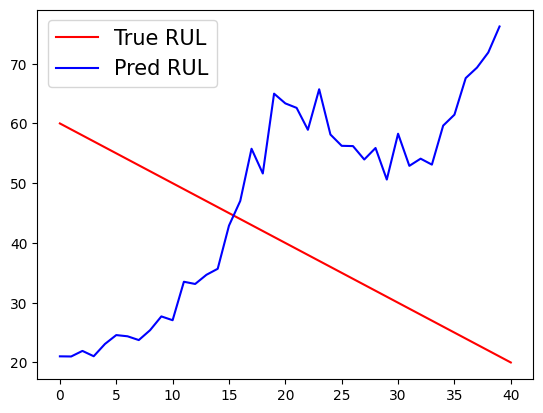

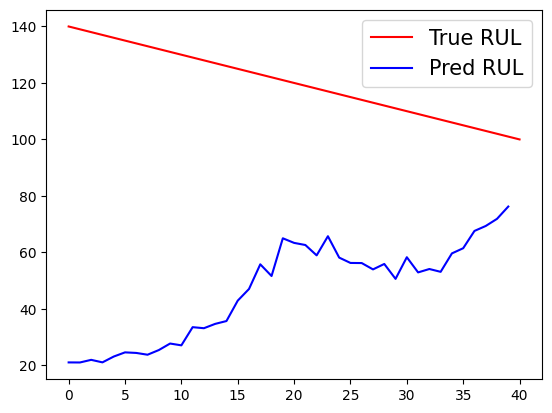

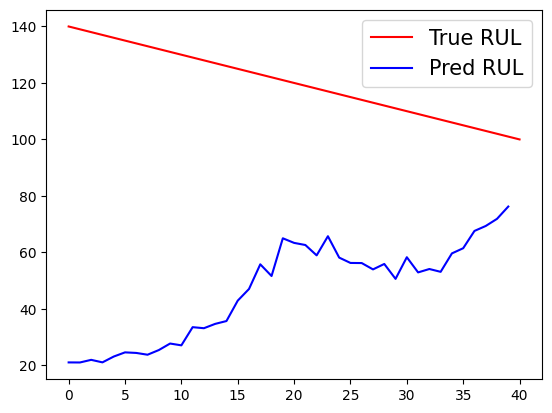

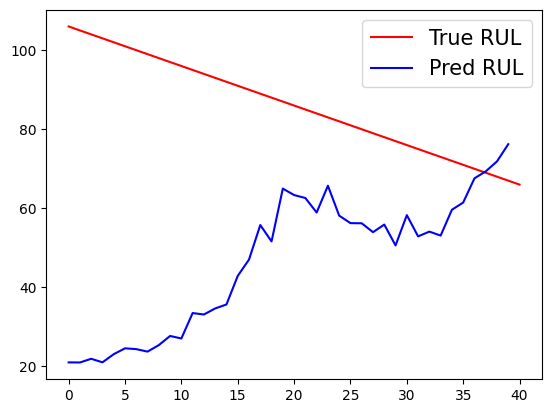

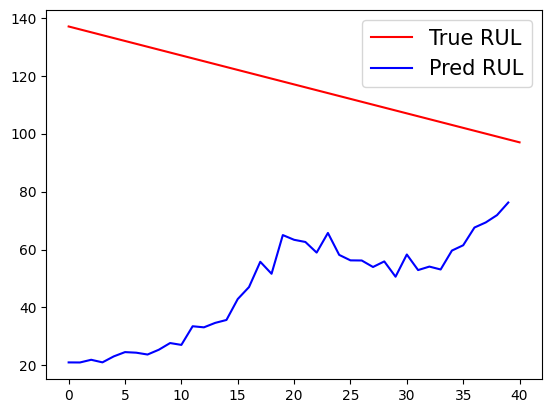

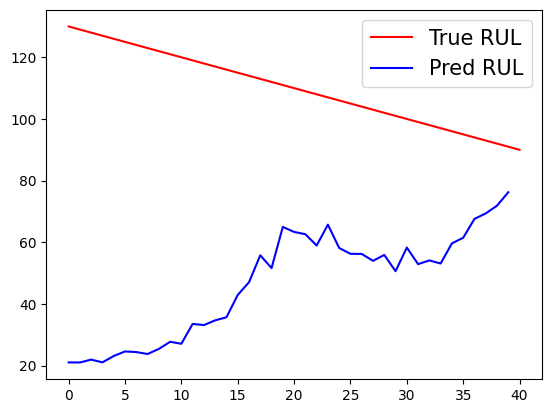

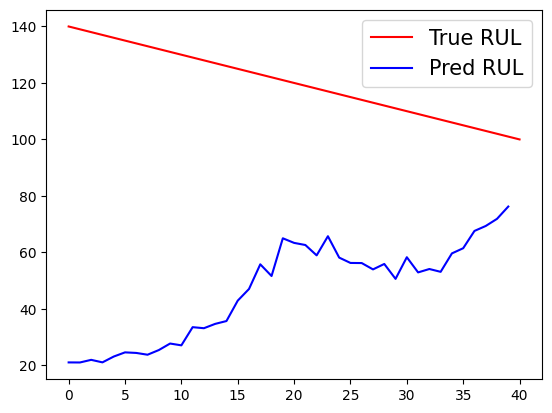

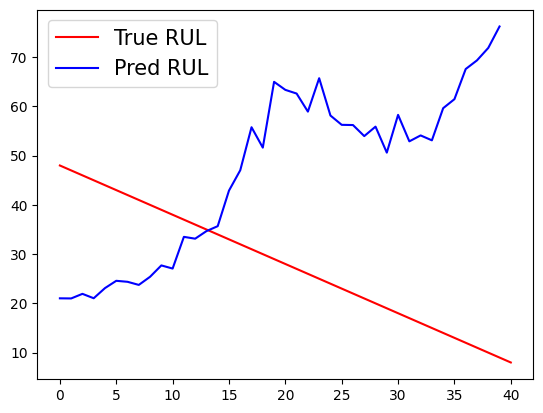

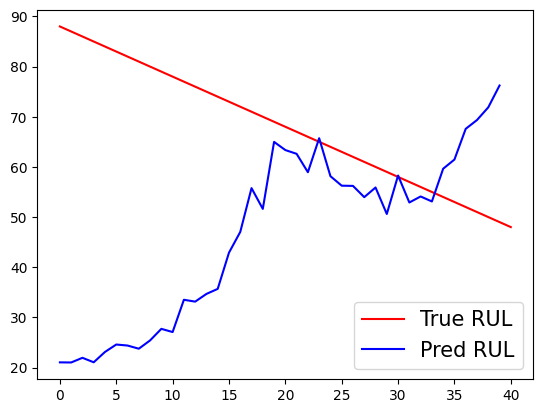

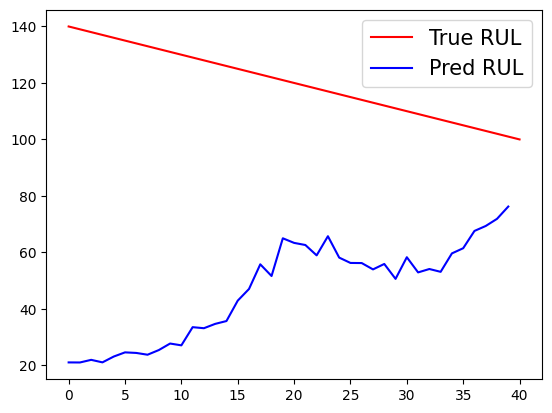

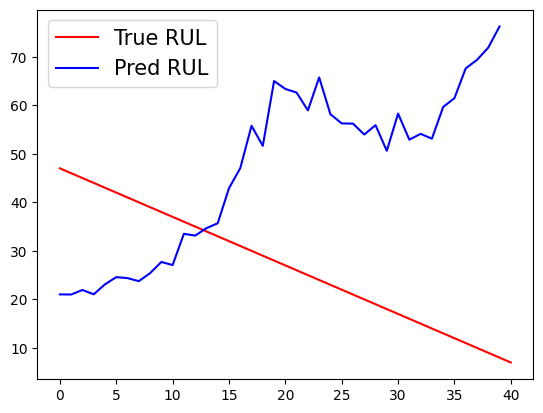

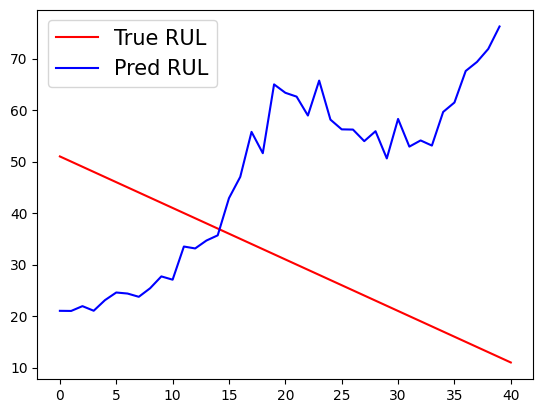

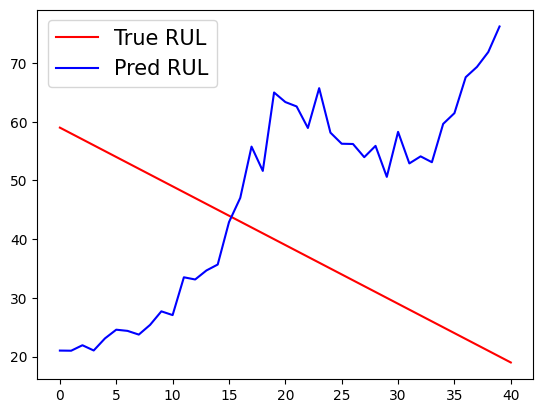

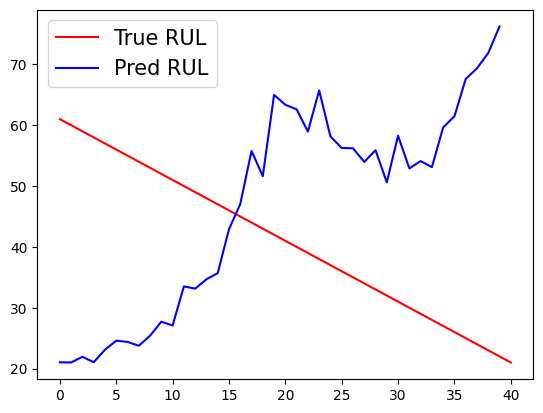

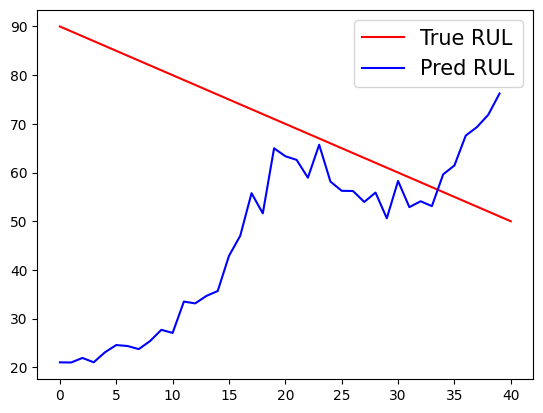

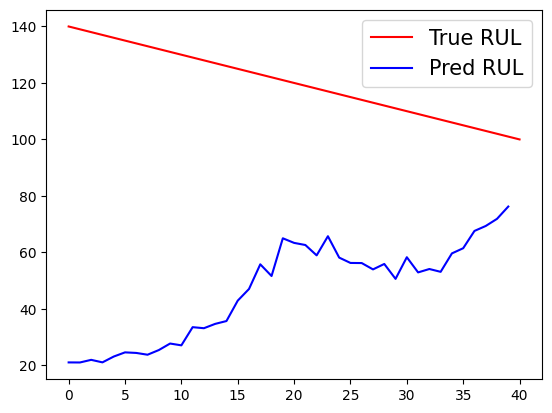

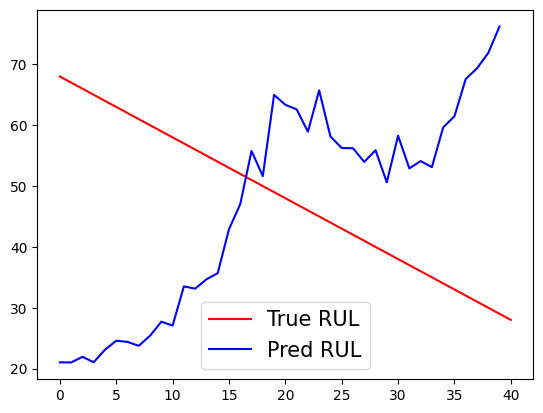

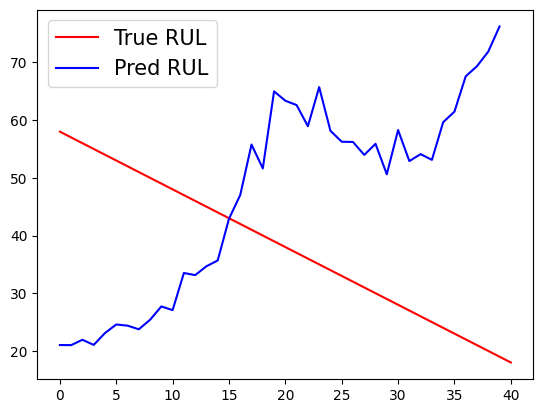

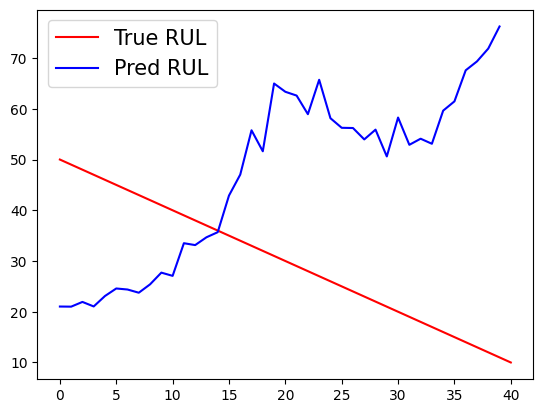

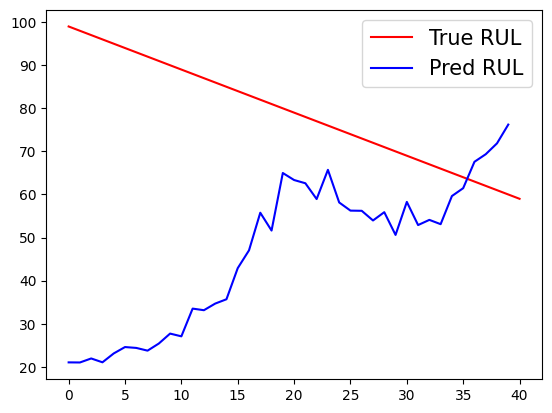

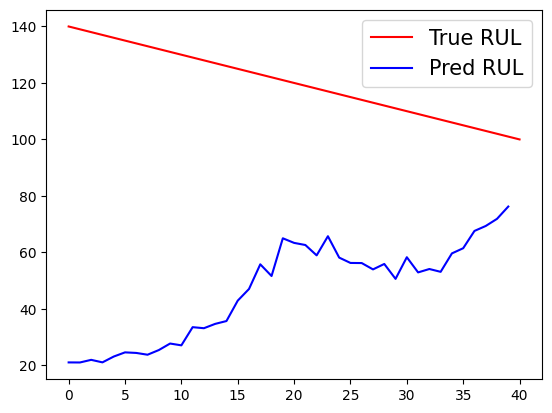

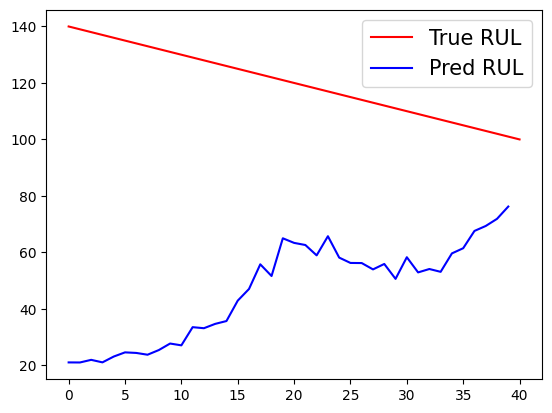

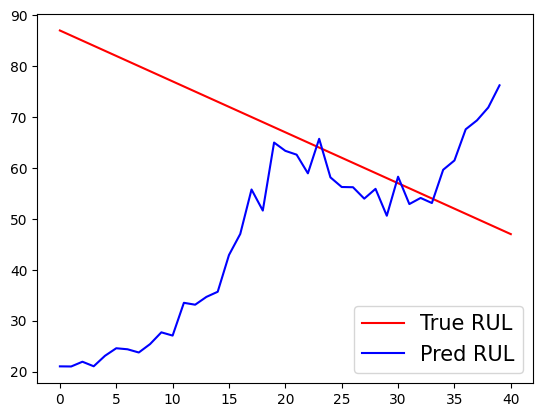

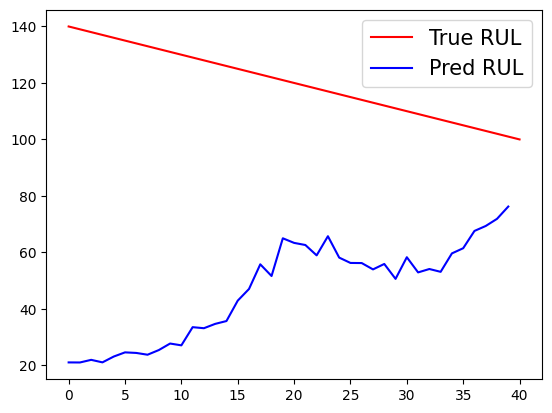

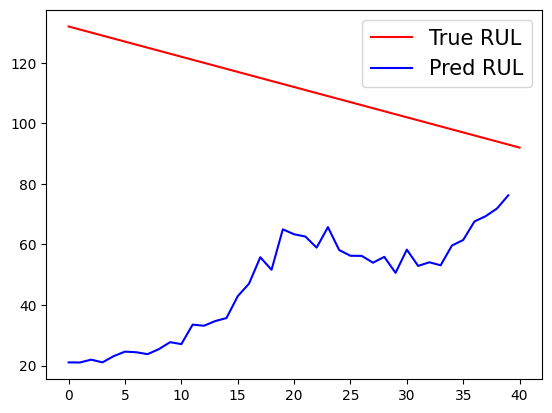

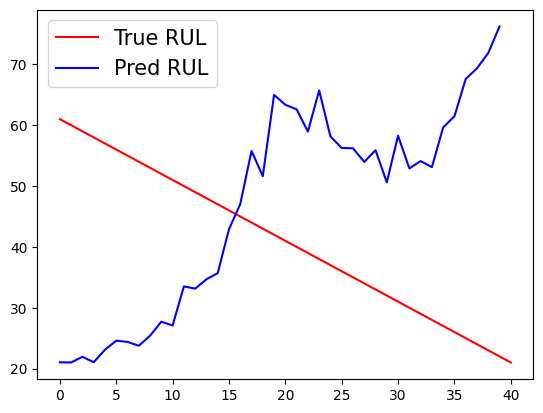

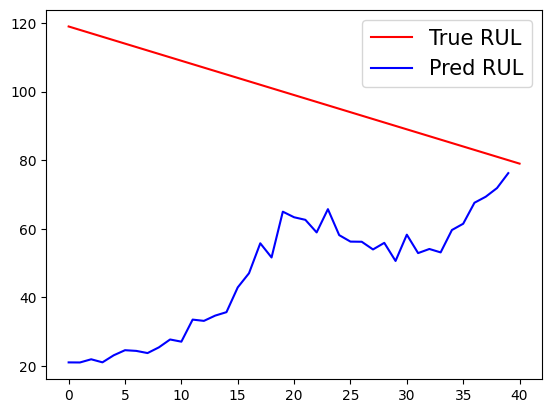

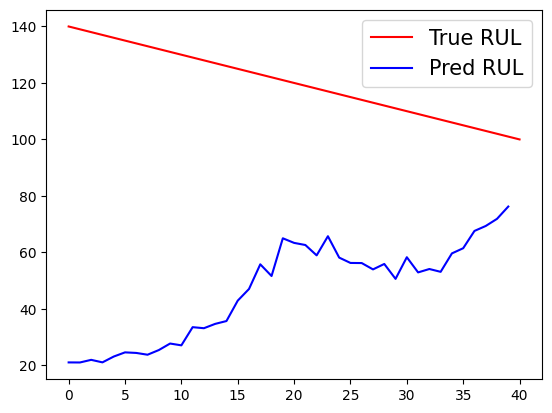

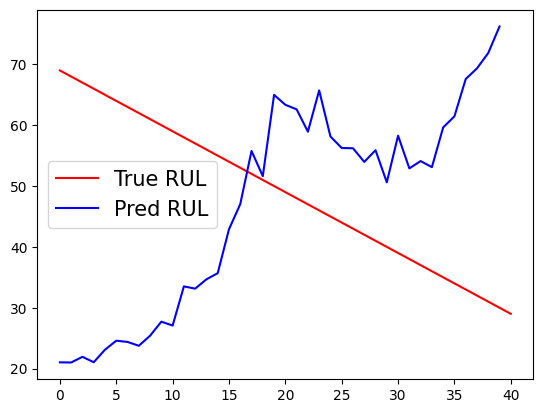

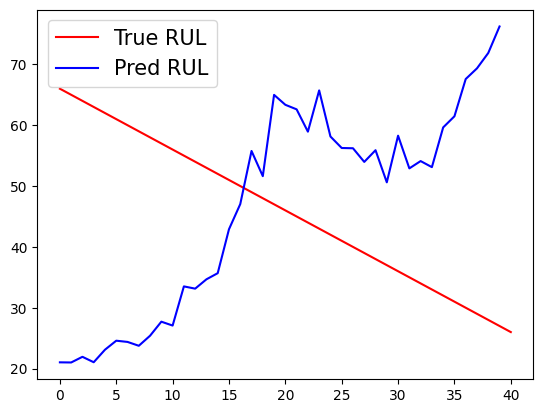

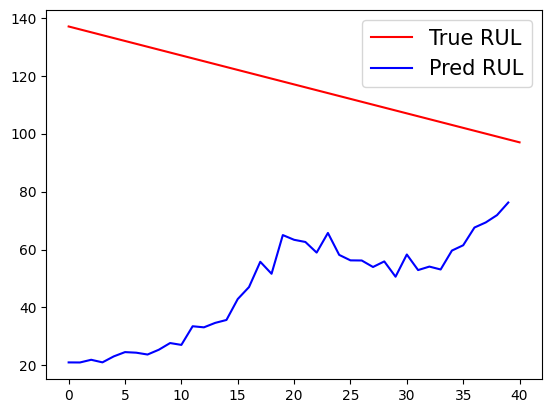

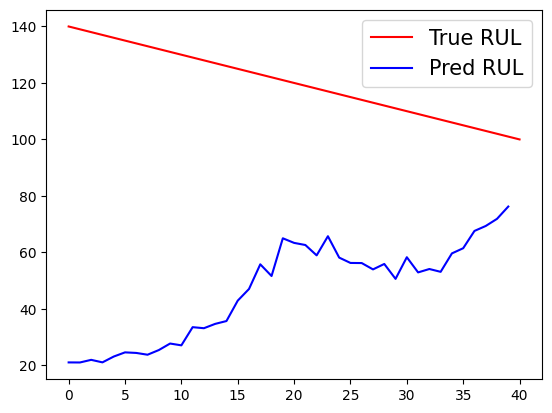

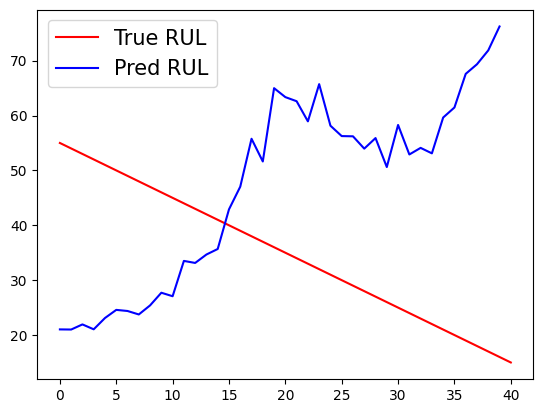

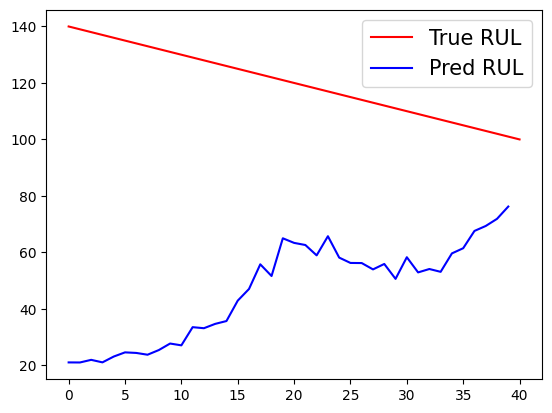

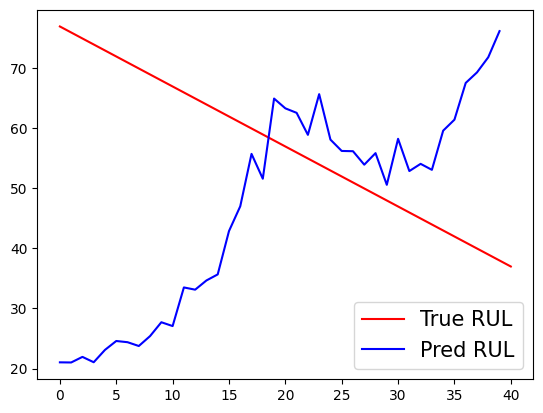

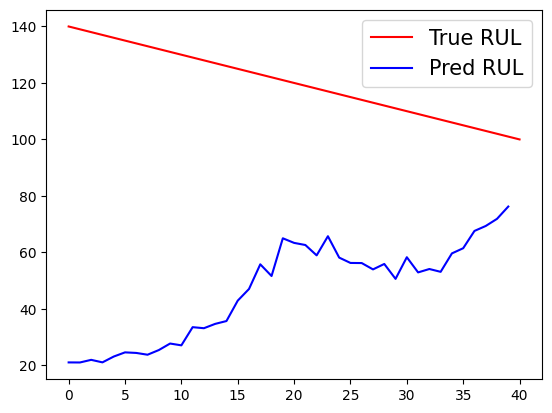

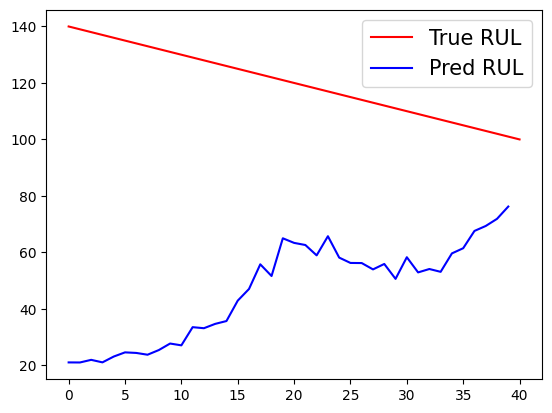

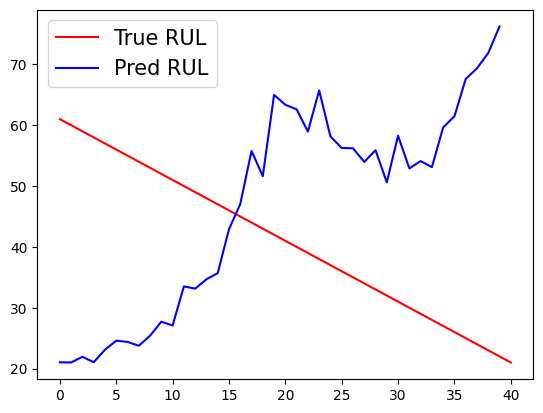

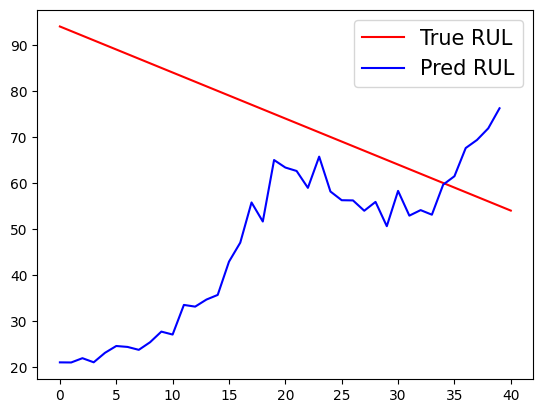

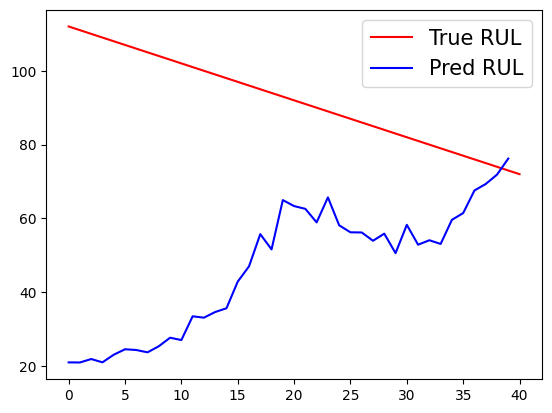

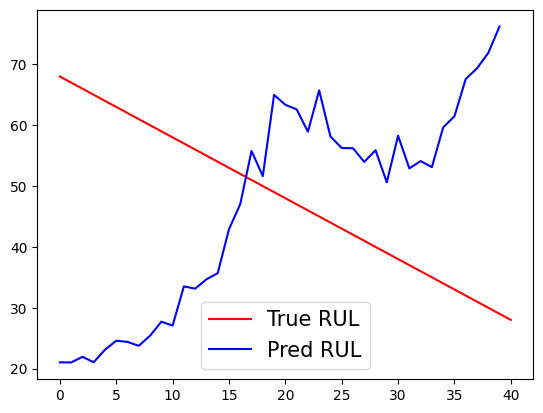

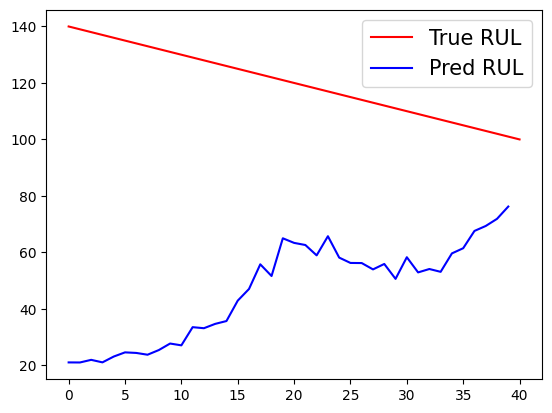

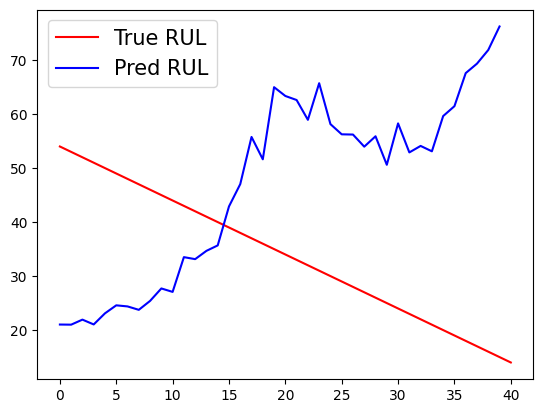

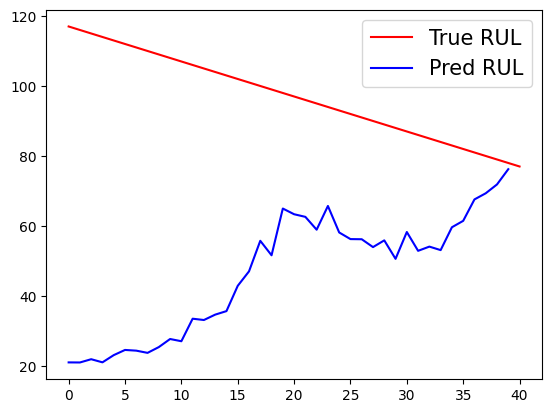

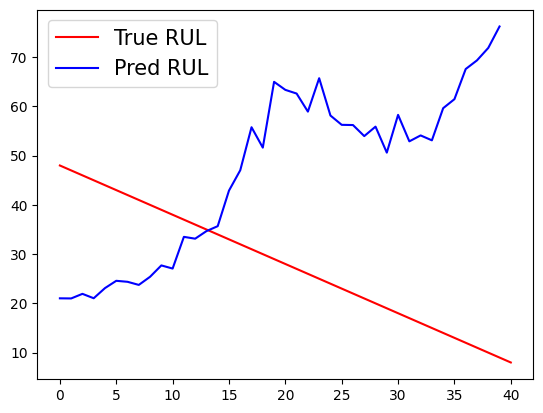

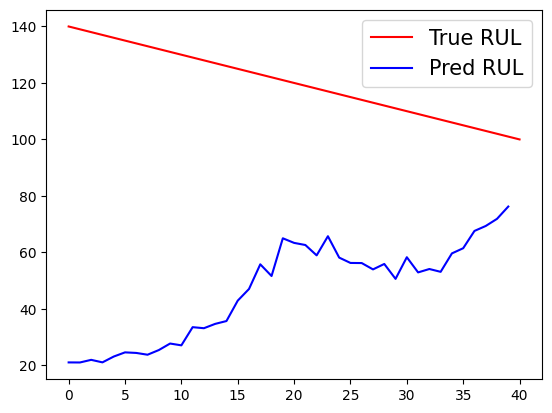

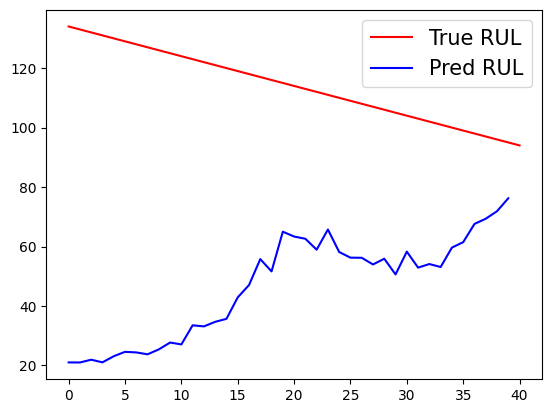

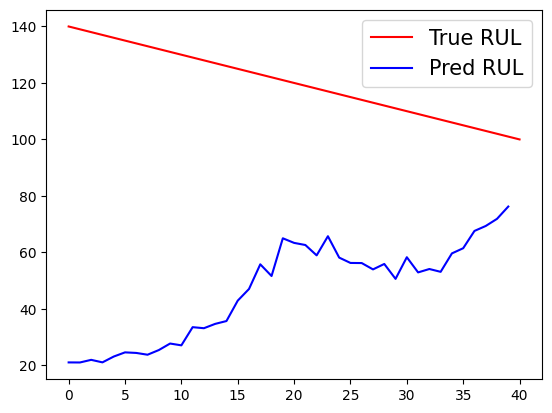

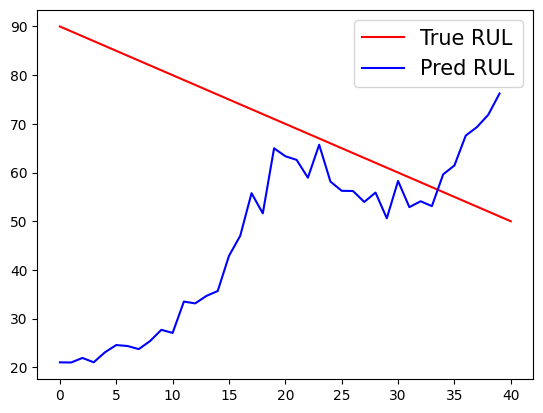

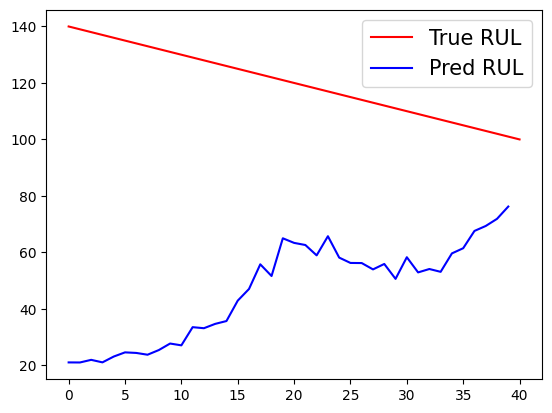

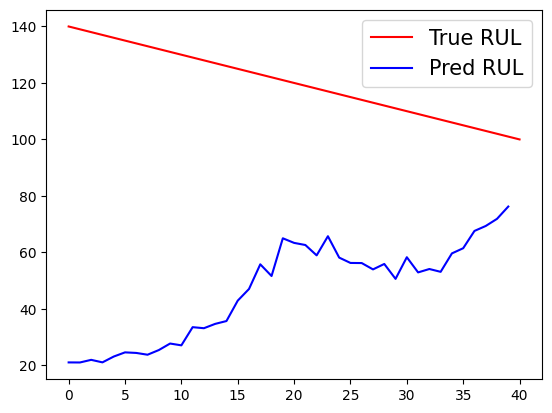

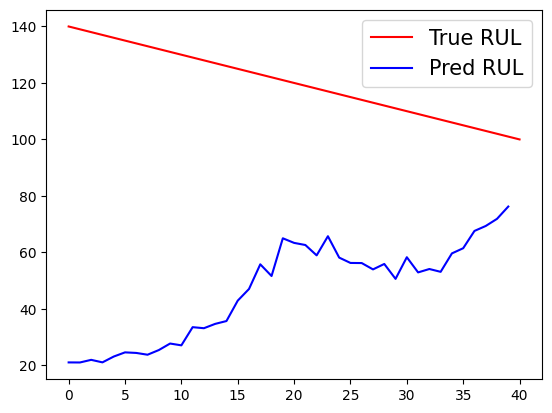

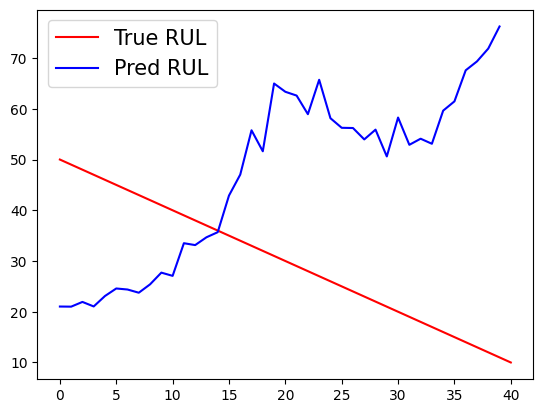

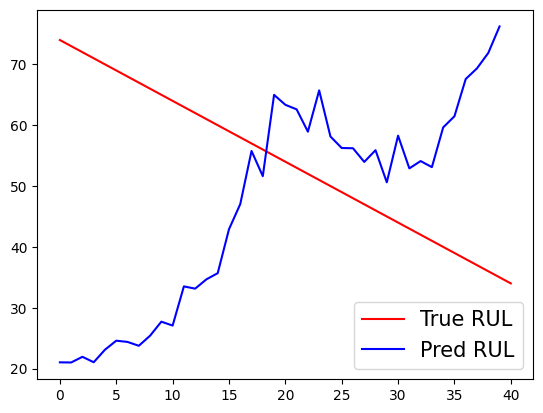

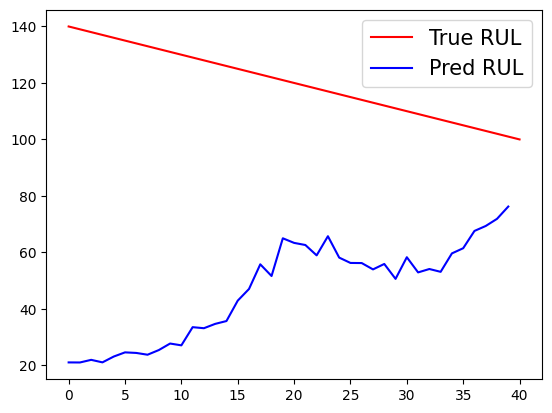

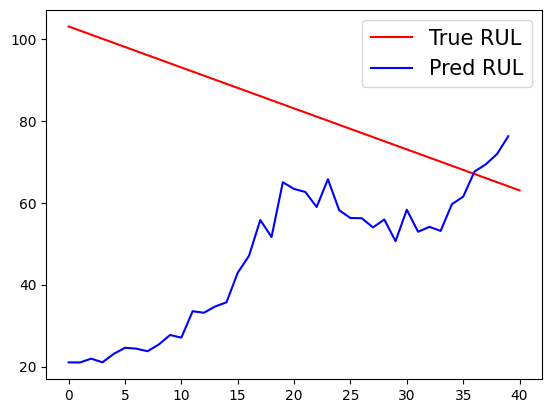

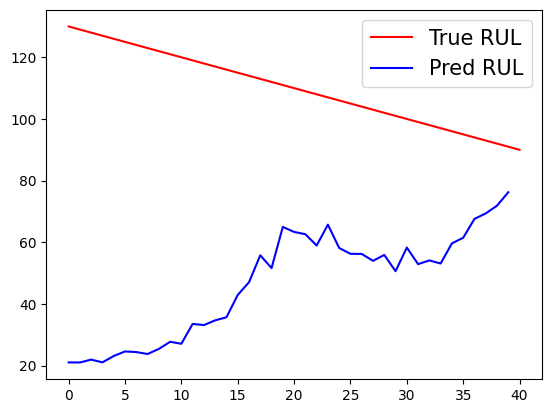

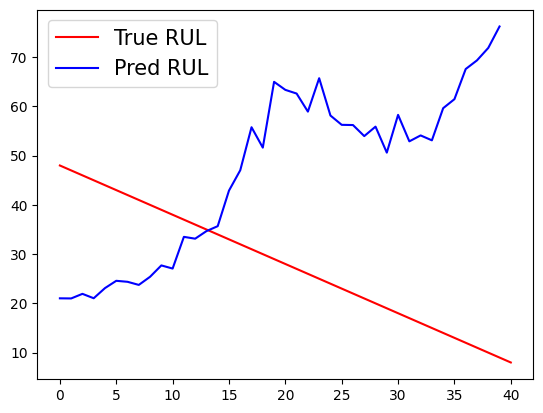

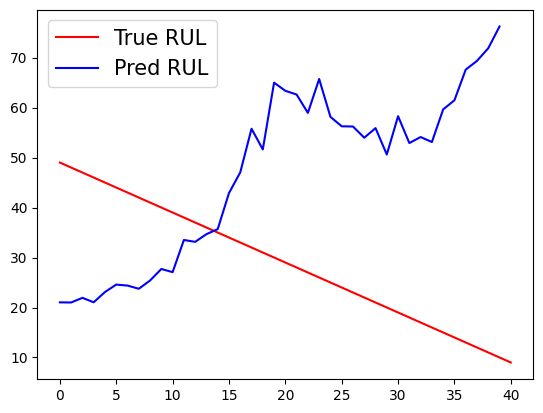

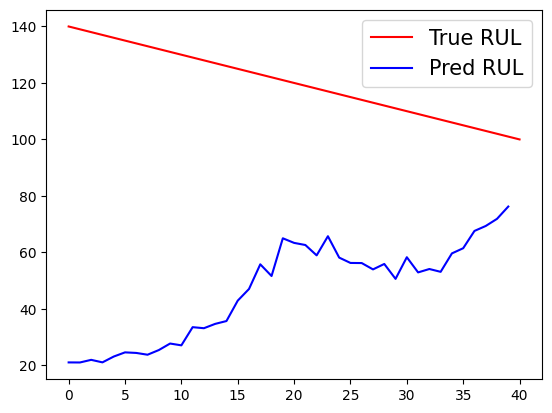

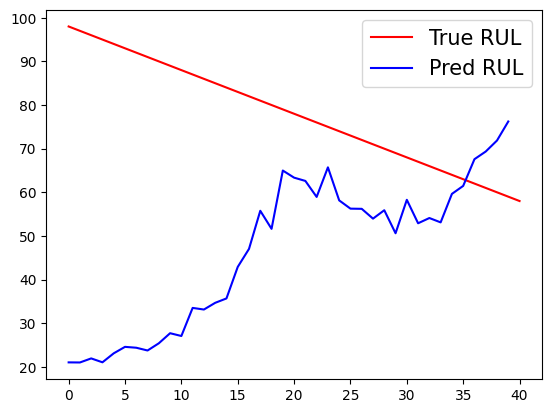

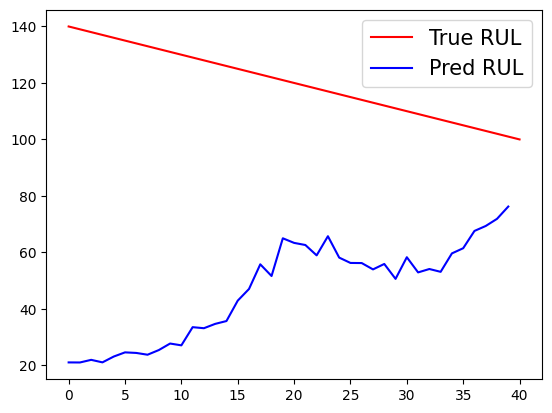

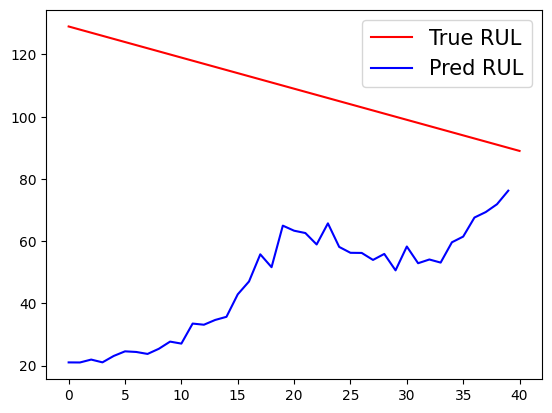

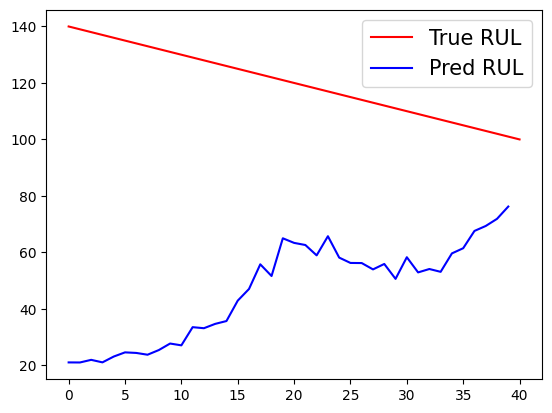

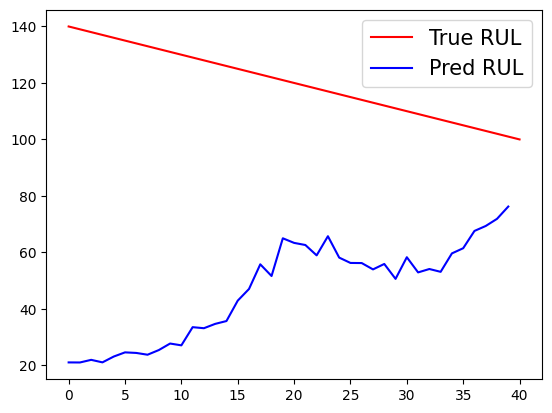

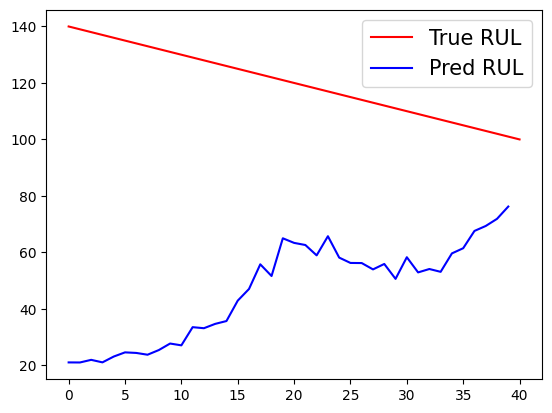

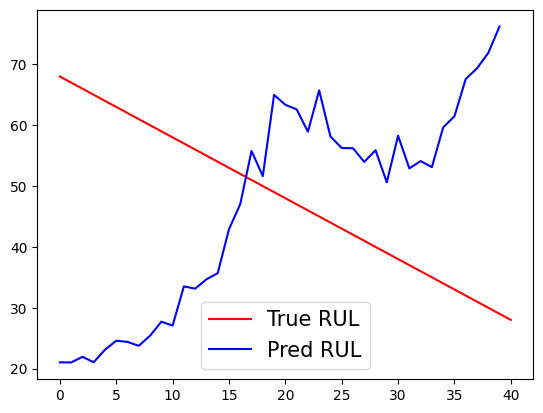

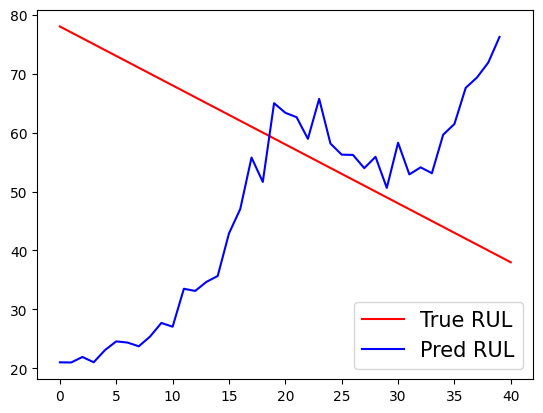

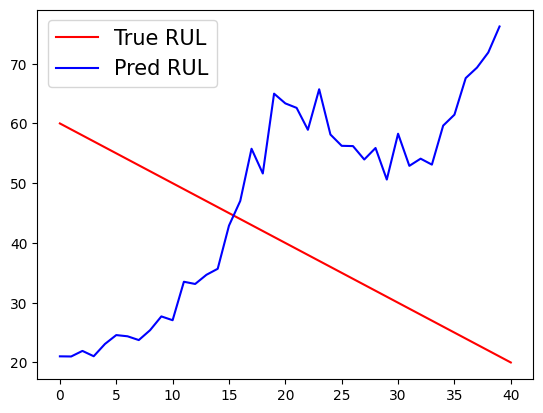

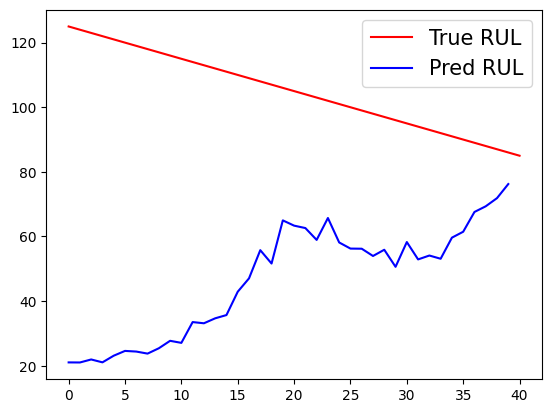

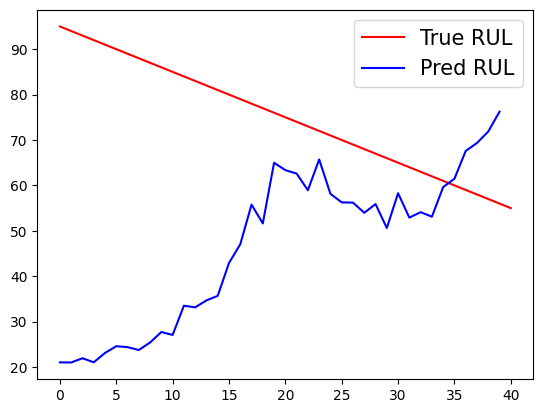

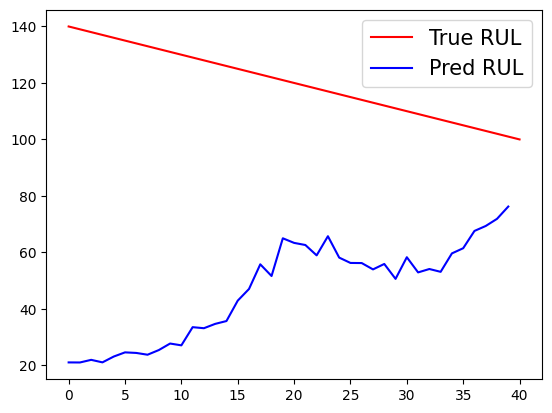

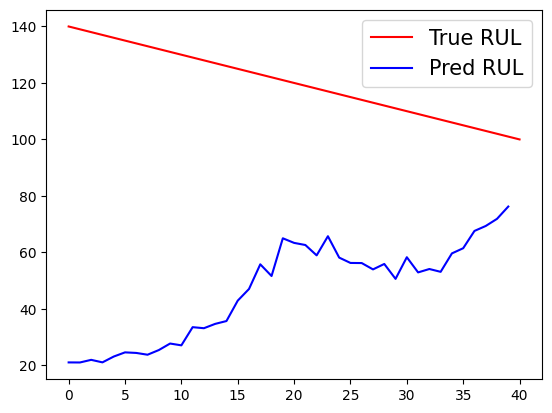

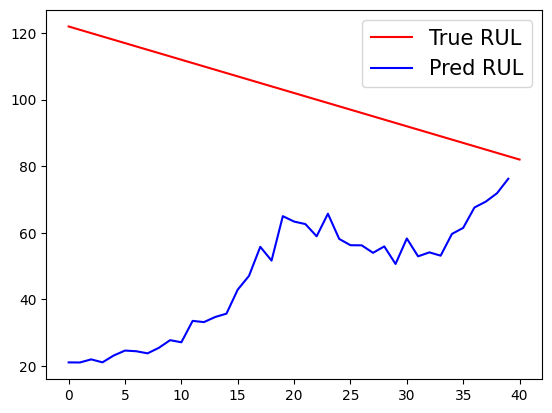

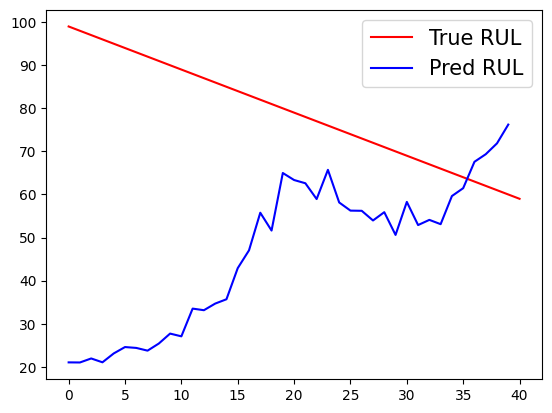

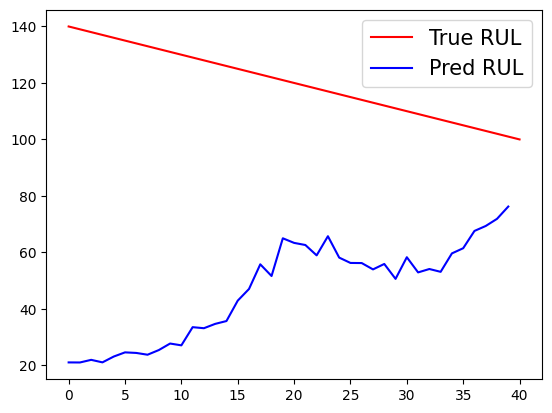

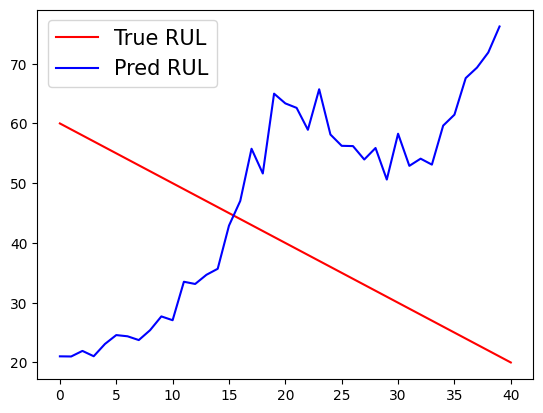

In [182]:
import numpy as np
for i in range(0,100):
    t1=list(reversed(list(main_li[i])))
    t2=list(reversed(list(preds_for_each_engine[j])))
    plot(t1,t2)


In [183]:
#Checking accuaracy for N cycles
def Accuracy(true_RUL,preds_for_last_example):
  c=0
  N=15
  for i in range(len(true_RUL)):
      if(abs(true_RUL[i]-preds_for_last_example[i])<=N):
          c+=1
  acc=c/len(true_RUL)*100
  print("Accuracy:"+str(acc))
Accuracy(true_RUL,preds_for_last_example)


Accuracy:88.0


(array([ 1.,  3.,  1.,  2.,  1.,  5.,  5.,  6., 40., 17.,  6.,  5.,  2.,
         2.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([-26.80107117, -23.73403454, -20.66699791, -17.59996128,
        -14.53292465, -11.46588802,  -8.39885139,  -5.33181477,
         -2.26477814,   0.80225849,   3.86929512,   6.93633175,
         10.00336838,  13.07040501,  16.13744164,  19.20447826,
         22.27151489,  25.33855152,  28.40558815,  31.47262478,
         34.53966141]),
 <BarContainer object of 20 artists>)

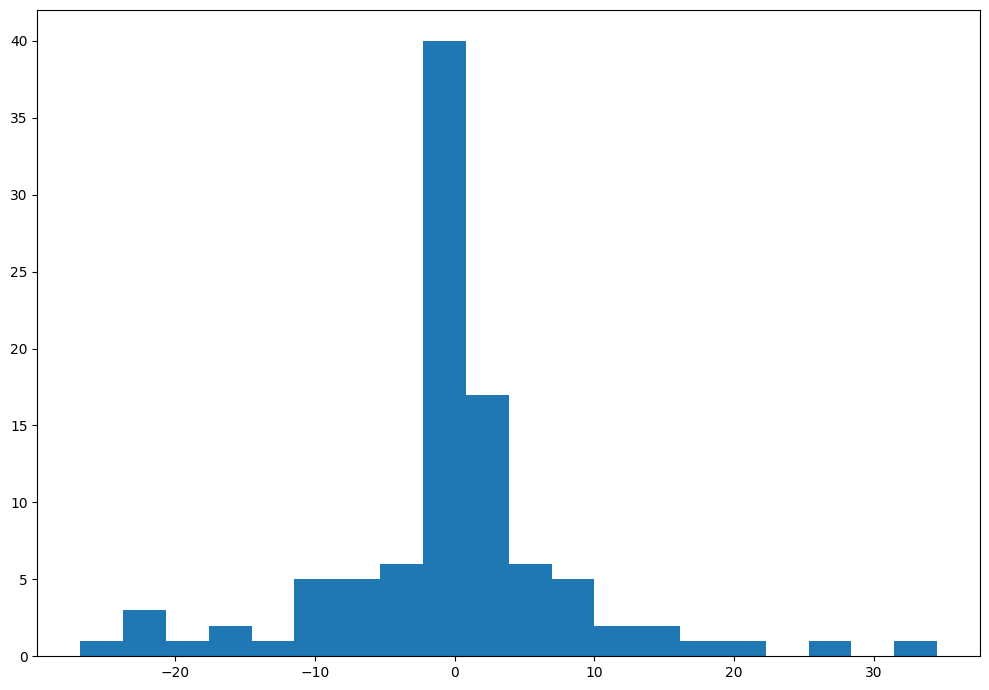

In [184]:
#Plot histogram distribution of errors in RUL prediction in cycles
c=[]
for i in range(len(true_RUL)):
    c.append((true_RUL[i]-preds_for_last_example[i]))
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs.hist(c, bins = 20)
 